**과목 : 머신러닝**

**학번 : 2017250037**

**이름 : 이현수**

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# 어레이 데이터를 csv 파일로 저장하기
def save_data(fileName, arrayName, header=''):
    np.savetxt(fileName, arrayName, delimiter=',', header=header, comments='')

# 데이터셋 불러오기
from sklearn import datasets
iris = datasets.load_iris()

import pandas as pd
import cv2 
import os 
from random import shuffle 
from tqdm import tqdm 
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

***과제 1 : 조기 종료를 사용한 배치 경사 하강법으로 로지스틱 회귀를 구현하라.
단, 사이킷런을 전혀 사용하지 않아야 한다.***

붓꽃 데이터셋의 꽃잎 길이(petal length)와 꽃잎 너비(petal width) 특성만 이용하여 데이터를 준비해준다.

타깃 2(버지니카 품종)를 1(양성)으로 지정하고 나머지를 0으로 처리해준다. 

In [2]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 넓이
y = (iris["target"] == 2).astype(np.int) # 버지니카 종 양성처리

모든 샘플에 편향을 추가한다. 이유는 아래 수식을 행렬 연산으로 보다 간단하게
처리하기 위해 0번 특성값 $x_0$이 항상 1이라고 가정하기 때문이다. 

$$
\theta_0\cdot 1 + \theta_1\cdot x_1 + \cdots + \theta_n\cdot x_n =
\theta_0\cdot x_0 + \theta_1\cdot x_1 + \cdots + \theta_n\cdot x_n
$$

In [3]:
X_with_bias = np.c_[np.ones([len(X), 1]), X]

데이터셋을 훈련, 검증, 테스트 용도로 6대 2대 2의 비율로 무작위로 분할한다.

- 훈련 세트: 60%
- 검증 세트: 20%
- 테스트 세트: 20%

In [4]:
test_ratio = 0.2                                         # 테스트 세트 비율 = 20%
validation_ratio = 0.2                                   # 검증 세트 비율 = 20%
total_size = len(X_with_bias)                            # 전체 데이터셋 크기

test_size = int(total_size * test_ratio)                 # 테스트 세트 크기: 전체의 20%
validation_size = int(total_size * validation_ratio)     # 검증 세트 크기: 전체의 20%
train_size = total_size - test_size - validation_size    # 훈련 세트 크기: 전체의 60%

`np.random.permutation()` 함수를 이용하여 인덱스를 무작위로 섞는다. 

In [5]:
rnd_indices = np.random.permutation(total_size)

인덱스가 무작위로 섞였기 때문에 무작위로 분할하는 효과를 얻는다.
방법은 섞인 인덱스를 이용하여 지정된 6:2:2의 비율로 훈련, 검증, 테스트 세트로 분할하는 것이다.

In [6]:
X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]

X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]

X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

타깃을 보면 버지니카 품종(1)과 아닌 것(0)들로 나눠진 것을 볼 수 있다. 

In [7]:
y_train[:5]

array([0, 0, 1, 0, 0])

학습을 위해 타깃을 원-핫 벡터로 변환해준다.

In [8]:
def to_one_hot(y):
    n_classes = y.max() + 1                 # 클래스 수
    m = len(y)                              # 샘플 수
    Y_one_hot = np.zeros((m, n_classes))    # (샘플 수, 클래스 수) 0-벡터 생성
    Y_one_hot[np.arange(m), y] = 1          # 샘플 별로 해당 클래스의 값만 1로 변경. (넘파이 인덱싱 활용)
    return Y_one_hot

In [9]:
y_train[:5]

array([0, 0, 1, 0, 0])

In [10]:
to_one_hot(y_train[:5])

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]])

이제 훈련/검증/테스트 세트의 타깃을 모두 원-핫 벡터로 변환한다.

In [11]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

사용할 시그모이드 함수를 정의한다.

In [12]:
def sigmoid(x):
	return 1 / (1 + np.exp(-x))

배치 경사하강법 훈련을 위한 준비를 한다.

In [13]:
n_inputs = X_train.shape[1]           # 특성 수(n) + 1, 붓꽃의 경우: 특성 2개 + 1
n_outputs = len(np.unique(y_train))   # 중복을 제거한 클래스 수(K), 붓꽃의 경우: 3개

In [14]:
Theta = np.random.randn(n_inputs, n_outputs)

In [15]:
#  배치 경사하강법 구현
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

for iteration in range(n_iterations):     # 5001번 반복 훈련
    x = X_train.dot(Theta)
    Y_proba = sigmoid(x)
    
    if iteration % 500 == 0:              # 500 에포크마다 손실(비용) 계산해서 출력
        loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        print(iteration, loss)
    
    error = Y_proba - Y_train_one_hot     # 그레이디언트 계산.
    gradients = 1/m * X_train.T.dot(error)
    
    Theta = Theta - eta * gradients       # 파라미터 업데이트

0 2.149647494733826
500 0.5487024796421114
1000 0.4617842956874686
1500 0.40677033684959657
2000 0.3690664894540297
2500 0.34152081461131945
3000 0.32038387250390116
3500 0.303541693458348
4000 0.2897223311716881
4500 0.2781170465346572
5000 0.2681872747895235


In [16]:
Theta

array([[ 3.47840651, -4.24152171],
       [ 0.02488763,  0.36181148],
       [-2.16143529,  1.48991542]])

검증 세트에 대한 예측과 정확도는 다음과 같다.
`logits`, `Y_proba`를 검증 세트인 `X_valid`를 이용하여 계산한다.
예측 클래스는 `Y_proba`에서 가장 큰 값을 갖는 인덱스로 선택한다.

In [17]:
x = X_valid.dot(Theta)              
Y_proba = sigmoid(x)
y_predict = np.argmax(Y_proba, axis=1)          # 가장 높은 확률을 갖는 클래스 선택

accuracy_score = np.mean(y_predict == y_valid)  # 정확도 계산
accuracy_score

0.9333333333333333

$\ell_2$ 규제가 추가된 경사하강법 훈련을 구현한다. 

In [18]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1        # 규제 하이퍼파라미터

Theta = np.random.randn(n_inputs, n_outputs)  # 파라미터 새로 초기화

for iteration in range(n_iterations):
    x = X_train.dot(Theta)
    Y_proba = sigmoid(x)
    
    if iteration % 500 == 0:
        xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        l2_loss = 1/2 * np.sum(np.square(Theta[1:]))  # 편향은 규제에서 제외
        loss = xentropy_loss + alpha * l2_loss        # l2 규제가 추가된 손실
        print(iteration, loss)
    
    error = Y_proba - Y_train_one_hot
    l2_loss_gradients = np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]   # l2 규제 그레이디언트
    gradients = 1/m * X_train.T.dot(error) + l2_loss_gradients
    
    Theta = Theta - eta * gradients

0 0.22618397955516528
500 0.37436420011642535
1000 0.3627533781464831
1500 0.36552549721355576
2000 0.36944697683236505
2500 0.37265942740061364
3000 0.37500676219163354
3500 0.3766494020653046
4000 0.37777552731296493
4500 0.37853906120634095
5000 0.37905344028438115


추가한 $\ell_2$ 규제가 그다지 영향이 없었음을 볼 수 있다. 정확도가 오히려 낮아졌다.

In [19]:
x = X_valid.dot(Theta)
Y_proba = sigmoid(x)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9

모델의 훈련 과정에서
매 에포크마다 검증 세트에 대한 손실을 계산하여 오차가 줄어들다가 증가하기 시작할 때 멈추도록 한다.

In [20]:
eta = 0.1 
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1            # 규제 하이퍼파라미터
best_loss = np.infty   # 최소 손실값 기억 변수

Theta = np.random.randn(n_inputs, n_outputs)  # 파라미터 새로 초기화

for iteration in range(n_iterations):
    # 훈련 및 손실 계산
    x = X_train.dot(Theta)
    Y_proba = sigmoid(x)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    # 검증 세트에 대한 손실 계산
    x = X_valid.dot(Theta)
    Y_proba = sigmoid(x)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    
    # 500 에포크마다 검증 세트에 대한 손실 출력
    if iteration % 500 == 0:
        print(iteration, loss)
        
    # 에포크마다 최소 손실값 업데이트
    if loss < best_loss:
        best_loss = loss
    else:                                      # 에포크가 줄어들지 않으면 바로 훈련 종료
        print(iteration - 1, best_loss)        # 종료되지 이전 에포크의 손실값 출력
        print(iteration, loss, "조기 종료!")
        break

0 1.174691380563007
500 0.4351280379791187
1000 0.4222719484749437
1039 0.42224368187573896
1040 0.4222436936592411 조기 종료!


훈련이 조기 종료 되었지만 검증 세트에 대한 정확도는 변하지 않은 것을 볼 수 있다.

In [21]:
x = X_valid.dot(Theta)
Y_proba = sigmoid(x)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9

전체 데이터셋에 대한 모델의 예측을 그래프로 그린다.

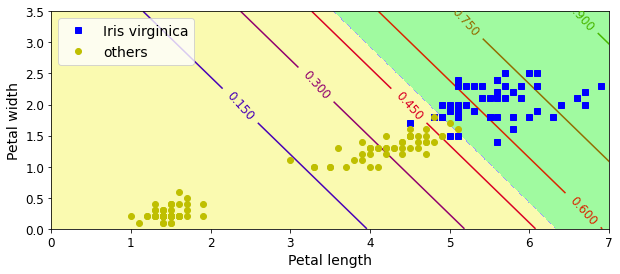

In [22]:
# (0, 8) x (0, 3.5) 크기의 직사각형 안의 모든 점을 대상으로 예측한 후에
# 예측 결과를 이용하여 색상으로 구분하고 등고선도 그리기 위한 준비작업
# 가로는 500개의 구간으로, 세로는 200개의 구간으로 쪼개짐.
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

# 직사각형 점 대상 예측하기
x = X_new_with_bias.dot(Theta)
Y_proba = sigmoid(x)
y_predict = np.argmax(Y_proba, axis=1)

# 등고선용 정보
zz1 = Y_proba[:, 1].reshape(x0.shape)                            # 버지니카 기준 예측 확률
zz = y_predict.reshape(x0.shape)                                 # 예측값

# 붓꽃 샘플 그리기
plt.figure(figsize=(10, 4))
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris virginica")  # 파랑 사각형, 버지니카 
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="others")      # 노랑 원, 다른 종들

# 등고선 그리기
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)                       # 노랑, 녹색 바탕색
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)              # 버지니카 기준 예측 확률 등고선
plt.clabel(contour, inline=1, fontsize=12)

# 기타 도표 정보
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

마지막으로 테스트 세트에 대한 모델의 최종 성능을 정확도로 측정한다.

In [23]:
x = X_test.dot(Theta)
Y_proba = sigmoid(x)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9666666666666667

최종 모델의 성능은 증가한 것을 볼 수 있다.

***과제 2 : 과제 1에서 구현된 로지스틱 회귀 알고리즘에 일대다(OvR) 방식을 적용하여 붓꽃에 대한 다중 클래스 분류 알고리즘을 구현하라. 단, 사이킷런을 전혀 사용하지 않아야 한다.***

로지스틱 회귀로 다중 분류를 하려면 현재 타깃이 3개니까 총 3번 각각 훈련시키고 결과를 얻으면 된다.

In [24]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 넓이
for c in range(0, 3):
  y = (iris["target"] == c).astype(np.int)

  X_with_bias = np.c_[np.ones([len(X), 1]), X]
  test_ratio = 0.2                                         # 테스트 세트 비율 = 20%
  validation_ratio = 0.2                                   # 검증 세트 비율 = 20%
  total_size = len(X_with_bias)                            # 전체 데이터셋 크기

  test_size = int(total_size * test_ratio)                 # 테스트 세트 크기: 전체의 20%
  validation_size = int(total_size * validation_ratio)     # 검증 세트 크기: 전체의 20%
  train_size = total_size - test_size - validation_size
  rnd_indices = np.random.permutation(total_size)

  X_train = X_with_bias[rnd_indices[:train_size]]
  y_train = y[rnd_indices[:train_size]]

  X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
  y_valid = y[rnd_indices[train_size:-test_size]]

  X_test = X_with_bias[rnd_indices[-test_size:]]
  y_test = y[rnd_indices[-test_size:]]
  
  Y_train_one_hot = to_one_hot(y_train)
  Y_valid_one_hot = to_one_hot(y_valid)
  Y_test_one_hot = to_one_hot(y_test)

  n_inputs = X_train.shape[1]
  n_outputs = len(np.unique(y_train))

  np.random.seed(42)

  Theta = np.random.randn(n_inputs, n_outputs)

  eta = 0.1 
  n_iterations = 5001
  m = len(X_train)
  epsilon = 1e-7
  alpha = 0.1            # 규제 하이퍼파라미터
  best_loss = np.infty   # 최소 손실값 기억 변수

  Theta = np.random.randn(n_inputs, n_outputs)  # 파라미터 새로 초기화

  for iteration in range(n_iterations):
    # 훈련 및 손실 계산
    x = X_train.dot(Theta)
    Y_proba = sigmoid(x)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    # 검증 세트에 대한 손실 계산
    x = X_valid.dot(Theta)
    Y_proba = sigmoid(x)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    
    # 500 에포크마다 검증 세트에 대한 손실 출력
    if iteration % 500 == 0:
        print(iteration, loss)
        
    # 에포크마다 최소 손실값 업데이트
    if loss < best_loss:
        best_loss = loss
    else:                                      # 에포크가 줄어들지 않으면 바로 훈련 종료
        print(iteration - 1, best_loss)        # 종료되지 이전 에포크의 손실값 출력
        print(iteration, loss, "조기 종료!")
        x = X_valid.dot(Theta)
        Y_proba = sigmoid(x)
        y_predict = np.argmax(Y_proba, axis=1)

        accuracy_score = np.mean(y_predict == y_valid)
        print("검증세트 정확도 :", accuracy_score)
        x = X_test.dot(Theta)
        Y_proba = sigmoid(x)
        y_predict = np.argmax(Y_proba, axis=1)

        accuracy_score = np.mean(y_predict == y_test)
        print("최종 정확도 :", accuracy_score)
        print("")

        break

0 0.7475900976070237
397 0.2623119851700346
398 0.2623121603205105 조기 종료!
검증세트 정확도 : 1.0
최종 정확도 : 1.0

0 0.6686012604092842
2 0.5603710264405453
3 0.5692159095193872 조기 종료!
검증세트 정확도 : 0.6666666666666666
최종 정확도 : 0.5666666666666667

0 0.5312784285326633
1 0.5079103977837676
2 0.5247268416999588 조기 종료!
검증세트 정확도 : 0.6666666666666666
최종 정확도 : 0.5666666666666667



과제 3 : 

A. 사진을 낮과 밤으로 분류하는 로지스틱 회귀 모델을 구현하라.

B. 사진을 낮과 밤, 실내와 실외로 분류하는 다중 레이블 분류 모델을 두 개의 로지스틱 회귀 모델을 이용하여 구현하라.

C. 과제 1에서 구현한 자신의 알고리즘과 사이킷런에서 제공하는 LogisticRegression 모델의 성능을 비교하라.

단, 모델 구현에 필요한 사진을 직접 구해야 한다. 최소 100장 이상의 사진 활용해야 한다.

이미지를 구글 드라이브를 통해 다운받는다.

In [25]:
from urllib import request
url = "https://docs.google.com/uc?export=download&id=1emB4lSxEzxzEt7_20w2DZ_Dw1sYS1grA"
request.urlretrieve(url,"day_night.zip")

('day_night.zip', <http.client.HTTPMessage at 0x7fc4463c9890>)

압축 파일을 풀고 경로를 나눠준다.

In [26]:
import os
import zipfile

local_zip = '/content/day_night.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()

In [27]:
train_day = "day_night/train/day"
train_night= "day_night/train/night"
test_day= "day_night/test/day"
test_night= "day_night/test/night"
image_size = 128

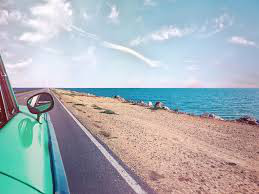

In [34]:
Image.open("day_night/train/day/day_130.jpg")

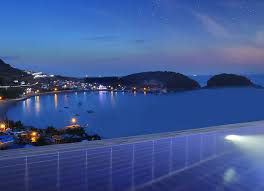

In [35]:
Image.open("day_night/train/night/night_130.jpg")

사진들의 크기가 각각 차이가 있어 이를 해결해주어야한다. 

Open CV 2를 이용하여 맞춰주겠다.

100%|██████████| 400/400 [00:00<00:00, 1617.57it/s]


Text(0.5, 1.0, 'day and night in GrayScale')

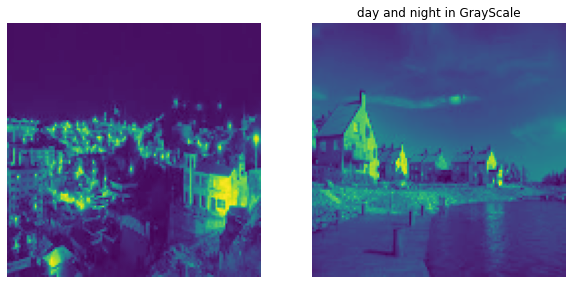

In [37]:
for image in tqdm(os.listdir(train_night)): 
    path = os.path.join(train_night, image)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
    img = cv2.resize(img, (image_size, image_size)).flatten()   
    np_img=np.asarray(img)
    
for image2 in tqdm(os.listdir(train_day)): 
    path = os.path.join(train_day, image2)
    img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
    img2 = cv2.resize(img2, (image_size, image_size)).flatten() 
    np_img2=np.asarray(img2)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(np_img.reshape(image_size, image_size))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(np_img2.reshape(image_size, image_size))
plt.axis('off')
plt.title("day and night in GrayScale")

In [38]:
def train_data():
    train_data_night = [] 
    train_data_day=[]
    for image1 in tqdm(os.listdir(train_night)): 
        path = os.path.join(train_night, image1)
        img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img1 = cv2.resize(img1, (image_size, image_size))
        train_data_night.append(img1) 
    for image2 in tqdm(os.listdir(train_day)): 
        path = os.path.join(train_day, image2)
        img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img2 = cv2.resize(img2, (image_size, image_size))
        train_data_day.append(img2) 
    
    train_data= np.concatenate((np.asarray(train_data_night),np.asarray(train_data_day)),axis=0)
    return train_data 

In [39]:
def test_data():
    test_data_night = [] 
    test_data_day=[]
    for image1 in tqdm(os.listdir(test_night)): 
        path = os.path.join(test_night, image1)
        img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img1 = cv2.resize(img1, (image_size, image_size))
        test_data_night.append(img1) 
    for image2 in tqdm(os.listdir(test_day)): 
        path = os.path.join(test_day, image2)
        img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img2 = cv2.resize(img2, (image_size, image_size))
        test_data_day.append(img2) 
    
    test_data= np.concatenate((np.asarray(test_data_night),np.asarray(test_data_day)),axis=0) 
    return test_data 

In [40]:
train_data = train_data() 
test_data = test_data()

100%|██████████| 100/100 [00:00<00:00, 1684.76it/s]


In [41]:
x_data=np.concatenate((train_data,test_data),axis=0)
x_data = (x_data-np.min(x_data))/(np.max(x_data)-np.min(x_data))

In [42]:
z1 = np.zeros(400)
o1 = np.ones(400)
Y_train = np.concatenate((o1, z1), axis=0)
z = np.zeros(100)
o = np.ones(100)
Y_test = np.concatenate((o, z), axis=0)

In [43]:
y_data=np.concatenate((Y_train,Y_test),axis=0).reshape(x_data.shape[0],1)

In [44]:
print("X shape: " , x_data.shape)
print("Y shape: " , y_data.shape)

X shape:  (1000, 128, 128)
Y shape:  (1000, 1)


In [45]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=42)
number_of_train = x_train.shape[0]
number_of_test = x_test.shape[0]

In [46]:
x_train_flatten = x_train.reshape(number_of_train,x_train.shape[1]*x_train.shape[2])
x_test_flatten = x_test .reshape(number_of_test,x_test.shape[1]*x_test.shape[2])
print("X train flatten",x_train_flatten.shape)
print("X test flatten",x_test_flatten.shape)

X train flatten (850, 16384)
X test flatten (150, 16384)


In [47]:
x_train = x_train_flatten.T
x_test = x_test_flatten.T
y_test = y_test.T
y_train = y_train.T
day_night_y_test = y_test
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (16384, 850)
x test:  (16384, 150)
y train:  (1, 850)
y test:  (1, 150)


In [50]:
def initialize_weights_and_bias(dimension):
    w = np.full((dimension,1),0.01)
    b = 0.0
    return w, b

def sigmoid(z):
    y_head = 1/(1+np.exp(-z))
    return y_head

def forward_backward_propagation(w,b,x_train,y_train):
    # forward propagation
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z)
    loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
    cost = (np.sum(loss))/x_train.shape[1]
    # backward propagation
    derivative_weight = (np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1]
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]
    gradients = {"derivative_weight": derivative_weight,"derivative_bias": derivative_bias}
    return cost,gradients

def update(w, b, x_train, y_train, learning_rate,number_of_iterarion):
    cost_list = []
    cost_list2 = []
    index = []
    
    for i in range(number_of_iterarion):
        
        cost,gradients = forward_backward_propagation(w,b,x_train,y_train)
        cost_list.append(cost)
        
        w = w - learning_rate * gradients["derivative_weight"]
        b = b - learning_rate * gradients["derivative_bias"]
        if i % 100 == 0:
            cost_list2.append(cost)
            index.append(i)
            print ("Cost after iteration %i: %f" %(i, cost))
    
    parameters = {"weight": w,"bias": b}
    plt.plot(index,cost_list2)
    plt.xticks(index,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    return parameters, gradients, cost_list

def predict(w,b,x_test):
    
    z = sigmoid(np.dot(w.T,x_test)+b)
    Y_prediction = np.zeros((1,x_test.shape[1]))

    for i in range(z.shape[1]):
        if z[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

def logistic_regression(x_train, y_train, x_test, y_test, learning_rate ,  num_iterations):

    dimension =  x_train.shape[0]
    w,b = initialize_weights_and_bias(dimension)

    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,num_iterations)
    
    y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)
    y_prediction_train = predict(parameters["weight"],parameters["bias"],x_train)
    
    print("Test Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100,2)))
    print("Train Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100,2)))

Cost after iteration 0: nan
Cost after iteration 100: 0.497620
Cost after iteration 200: 1.758121
Cost after iteration 300: 0.426016
Cost after iteration 400: 0.391724
Cost after iteration 500: 0.387556
Cost after iteration 600: 0.387694
Cost after iteration 700: 0.395121
Cost after iteration 800: 0.364832
Cost after iteration 900: 0.336300
Cost after iteration 1000: 0.309999
Cost after iteration 1100: 0.285596
Cost after iteration 1200: 0.262917
Cost after iteration 1300: 0.241918
Cost after iteration 1400: 0.222625


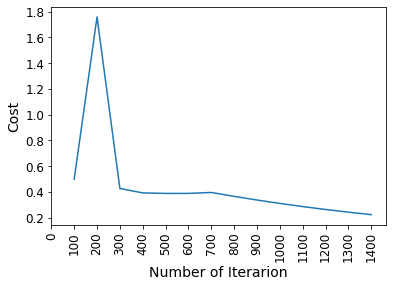

Test Accuracy: 82.67 %
Train Accuracy: 95.41 %


In [51]:
logistic_regression(x_train, y_train, x_test, y_test,learning_rate = 0.01, num_iterations = 1500)

train_set 비해 test_set에 대한 성능이 낮게 나왔고

과대적합이 의심된다.